In [1]:
import torch
import random
import random
import torch
import torch.nn as nn 
import torch.backends.cudnn as cudnn 
import torch.optim as optim
from torchvision.utils import make_grid
from backbones import get_model
from privacy_pipeline import Pipeline
import torch.nn.functional as F
import math
from IPython.display import clear_output
from IPython import display
import matplotlib.pyplot as plt
from torchvision.utils import save_image
from IPython.display import Image as showIm
from IPython.display import display
import numpy as np
# from torchvsion.model import res

In [2]:
class DeepInversionFeatureHook():
    def __init__(self, module):
        self.hook = module.register_forward_hook(self.hook_fn)
    def hook_fn(self, module, input, output):
        nch = input[0].shape[1]
        mean = input[0].mean([2, 3])
        var = input[0].contiguous().view([bs,nch, -1]).var(2, unbiased=False)
#         print(input[0].shape,module.running_var.shape)
        r_feature = torch.norm(module.running_var.data - var, 2,dim=1) + torch.norm(
            module.running_mean.data - mean, 2,dim=1)
        self.r_feature = r_feature
#         print(r_feature.shape)
    def close(self):
        self.hook.remove()

In [3]:
a = torch.ones(10,5)
torch.sum(a,dim=1)

tensor([5., 5., 5., 5., 5., 5., 5., 5., 5., 5.])

In [4]:
def get_image_prior_losses(inputs_jit):
    diff1 = inputs_jit[:, :, :, :-1] - inputs_jit[:, :, :, 1:]
    diff2 = inputs_jit[:, :, :-1, :] - inputs_jit[:, :, 1:, :]
    diff3 = inputs_jit[:, :, 1:, :-1] - inputs_jit[:, :, :-1, 1:]
    diff4 = inputs_jit[:, :, :-1, :-1] - inputs_jit[:, :, 1:, 1:]
    norm = lambda x:torch.norm(x,dim=[2,3]).sum(dim=1)
    loss_var_l2 = norm(diff1) + norm(diff2) + norm(diff3) + norm(diff4)
    loss_var_l1 = (diff1.abs() / 255.0).mean() + (diff2.abs() / 255.0).mean() + (
            diff3.abs() / 255.0).mean() + (diff4.abs() / 255.0).mean()
    loss_var_l1 = loss_var_l1 * 255.0
    return loss_var_l1, loss_var_l2

In [5]:
image_resolution = 112
do_flip = True
net = get_model('r100',fp16=False).eval().cuda()
net.load_state_dict(torch.load('/private/data/backbone.pth'));

In [6]:
r_feature_layers = [] 
for module in net.modules():
    if isinstance(module,nn.BatchNorm2d):
        r_feature_layers.append(DeepInversionFeatureHook(module))

In [7]:
def lr_policy(lr_fn):
    def _alr(optimizer, iteration, epoch):
        lr = lr_fn(iteration, epoch)
        for param_group in optimizer.param_groups:
            param_group['lr'] = lr

    return _alr

def lr_cosine_policy(base_lr, warmup_length, epochs):
    def _lr_fn(iteration, epoch):
        if epoch < warmup_length:
            lr = base_lr * (epoch + 1) / warmup_length
        else:
            e = epoch - warmup_length
            es = epochs - warmup_length
            lr = 0.5 * (1 + np.cos(np.pi * e / es)) * base_lr
        return lr

    return lr_policy(_lr_fn)

In [8]:
bs = 16
emb_target = torch.load('save/emb_average.pt').cuda()
emb_target = emb_target.expand(bs,-1).cuda()
# cos_loss = torch.cosine_similarity(emb_target,emb_out)
# norm_loss = ((torch.norm(emb_target,dim=1)-torch.norm(emb_out,dim=1))**2)
best_loss = 1e4

tensor([0.9666, 0.9797, 0.9767, 0.9677, 0.9373, 0.9776, 0.9356, 0.9636, 0.9738,
        0.9381, 0.9662, 0.9801, 0.9635, 0.9838, 0.9397, 0.9796, 0.9727, 0.9578,
        0.9739, 0.9725, 0.9284, 0.9786, 0.9414, 0.9785, 0.9839, 0.9543, 0.9742,
        0.9796, 0.9519, 0.9710, 0.9436, 0.9774], device='cuda:0',
       grad_fn=<DivBackward0>)


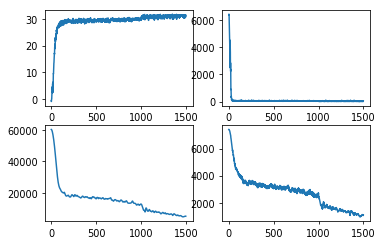

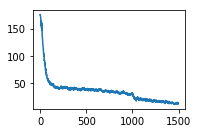

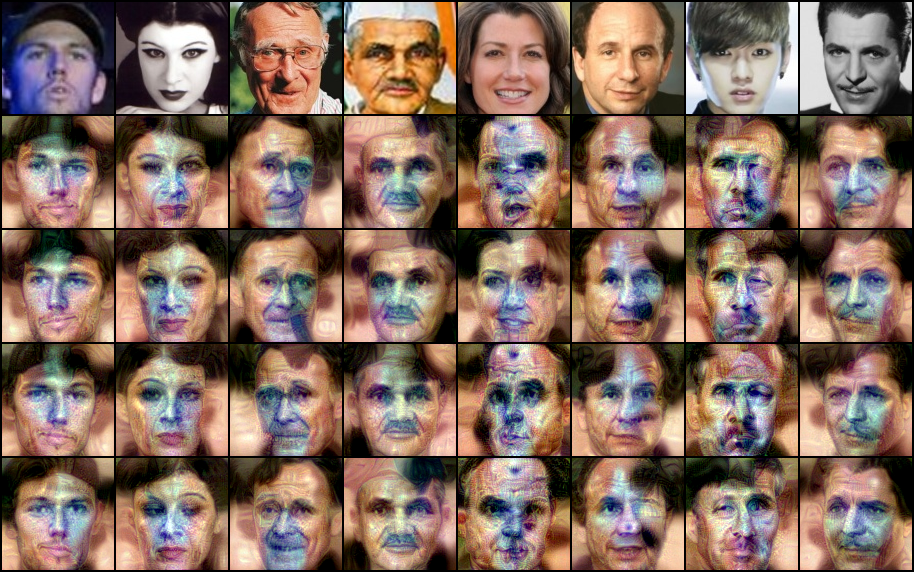

In [ ]:
stat = [[],[],[],[],[]]
emb_file ='save/multi.pt' #'save/emb_1.pt' # 'save/emb_average.pt'
# emb_file ='save/js.pt' #'save/emb_1.pt' # 'save/emb_average.pt'
# emb_target = torch.load(emb_file).cuda()
origin,emb_target = [i.cuda() for i in torch.load(emb_file)]
emb_target = torch.cat([emb_target,emb_target,emb_target,emb_target])
# emb_target = emb_target.expand(bs,-1).cuda()
#####################
lr = 0.25 #0.25
jitter = 3
epochs = 2000
c_cos,c_norm,c_bn,c_l2var = 2,0.002,0.005,0.001
flip_prob = 0.5
bn_first_scale = 10
bn_latter_scale = 0 ### not implemented
clamp = True
symmetry = False
bs = 32
start_noise = True
#####################
if not start_noise:inpu = torch.zeros((bs,3,image_resolution,image_resolution),requires_grad=True,device='cuda',dtype=torch.float)
else:inpu = torch.randn((bs,3,image_resolution,image_resolution),requires_grad=True,device='cuda',dtype=torch.float)
# optimizer = optim.Adam([inputs],lr=lr,betas=[0.5,0.9],eps=1e-8)
optimizer = optim.Adam([inpu], lr=lr, betas=(0.9,0.999), eps = 1e-8)
lr_scheduler = lr_cosine_policy(lr,100,epochs)
for epoch in range(epochs):
    lr_scheduler(optimizer, epoch,epoch)
    if epoch/epochs<0.5:
        off1 = random.randint(-jitter,jitter)
        off2 = random.randint(-jitter,jitter)
    else:
        off1,off2= 0,0
    inputs = torch.roll(inpu, shifts=(off1,off2),dims=(2,3))

    flip = random.random() > flip_prob
    if flip and do_flip:
        inputs = torch.flip(inputs, dims=(3,))
    optimizer.zero_grad()
    net.zero_grad()
    emb_out = net(inputs)
    cos_loss = torch.cosine_similarity(emb_target,emb_out)
    norm_loss = ((torch.norm(emb_target,dim=1)-torch.norm(emb_out,dim=1))**2)
    var_l1_loss, var_l2_loss = get_image_prior_losses(inputs)
    rescale = [bn_first_scale] + [1. for _ in range(len(r_feature_layers) - 1)]
    r_feature_loss = torch.stack([mod.r_feature * rescale[idx] for (idx,mod) in enumerate(r_feature_layers)]).sum(dim=0)
#     print(cos_loss.shape,norm_loss.shape,r_feature_loss.shape,var_l2_loss.shape)
#     l2_loss = torch.norm(inputs.view(bs,-1),dim=1).mean()
    
    loss =  -cos_loss * c_cos + \
                norm_loss * c_norm + \
                r_feature_loss * c_bn + \
            var_l2_loss * c_l2var
    
    loss.backward(torch.ones(bs).cuda())
    optimizer.step()
    with torch.no_grad():
        stat[0].append(cos_loss.sum().item())
        stat[1].append(norm_loss.sum().item())
        stat[2].append(var_l2_loss.sum().item())
        stat[3].append(r_feature_loss.sum().item())
        stat[4].append(loss.sum().item()+bs*c_cos)
        if symmetry : inputs[:] = (inputs + torch.flip(inputs,[3]))/2
#         if clamp: inputs.clamp(-1,1)
        if clamp: inputs.clamp(-1,1)
    if epoch %25 ==24:
        clear_output(wait=True)
        print(cos_loss)
        plt.figure(dpi=70)
        plt.subplot(221),plt.plot(stat[0]),plt.subplot(222),plt.plot(stat[1]),plt.subplot(223),plt.plot(stat[2]),plt.subplot(224),plt.plot(stat[3]),plt.show()
        plt.subplot(221), plt.plot(stat[4]), plt.show()
#         save_image(inputs.data.clone(),f'img/{epoch:04d}.png',normalize=True,value_range=(-1,1),nrow=8)
        save_image(torch.cat([origin,inputs.data.clone()]),f'img/{epoch:04d}.png',normalize=True,value_range=(-1,1),nrow=8)
        display(showIm(filename=f'img/{epoch:04d}.png'))

In [ ]:
torch.

In [ ]:
l = []
for i in range(5):
    l.append(torch.ones(10))
torch.stack(l).sum(dim=1)

In [ ]:
cos_loss,norm_loss,var_l2_loss

In [ ]:
a = torch.randn(10).requires_grad_()

In [ ]:
b = a * a * a
b.backward(torch.ones(10))
a.grad

In [ ]:
emb_target = torch.rand_like(emb_target).cuda()-0.5
emb_target

In [ ]:
torch.rand_like(emb_target)-0.5

In [ ]:
f'{epoch:04d}.png'

In [ ]:
startNoise = False

In [ ]:
a = torch.arange(25).view(5,5)

In [ ]:
a

In [ ]:
a[:,1]=(a[:,1]+a[:,2]+a[:,3])/3

In [ ]:
a

In [ ]:
import torch

In [ ]:
torch.ones(1000,100,10)
torch.randn(101,100).unsqueeze(2).expand(100,100,10).shape

In [ ]:
plt.plot?

In [ ]:
make_grid?